In [12]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer, RobertaForSequenceClassification
from transformers import AdamW
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy.spatial.distance import cosine
from sim_utils import load_examples, Inputexample, CustomTextDataset, freeze_layers, train, test
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoConfig, AutoModel, AutoTokenizer
#comment this if you are not using puffer
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [13]:
N = 5
data = []
labels = []

train_samples = []
train_labels = []

valid_samples = []
valid_labels = []

test_samples = []
test_labels = []

embed_dim = 768
batch_size = 16
lr=2e-3  # you can adjust 
temp = 0.3  # you can adjust 
lamda = 0.01  # you can adjust  
skip_time = 0 # the number of time that yi not equal to yj in supervised contrastive loss equation 
data_name = '64'
model_name = 'sup-simcse-bert'
shot_name = 'train_5'
exp_name = f'{model_name}_lr={lr}_t={temp}_{data_name}_{shot_name}'
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

### The Aim of these training is to fine tuning on few shot setting on text classification task

Path example of train, validation and test 

In [14]:
path_5shot = f'./HWU64/train_5/'
valid_path = f'./HWU64/valid/'
test_path = f'./HWU64/test/'

In [15]:
# Download data fewshot 
# https://downgit.github.io/#/home?url=https:%2F%2Fgithub.com%2Fjianguoz%2FFew-Shot-Intent-Detection%2Ftree%2Fmain%2FDatasets%2FHWU64

# load data
train_samples = load_examples(path_5shot)
valid_samples = load_examples(valid_path)
test_samples = load_examples(test_path)


print("===== small train set ====")

for i in range(len(train_samples)):
    data.append(train_samples[i].text)
    labels.append(train_samples[i].label)


train_data = CustomTextDataset(labels,data,batch_size=batch_size,repeated_label=False)
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)



print("===== validation set ====")

data = []
labels = []

for i in range(len(valid_samples)):
    data.append(valid_samples[i].text)
    labels.append(valid_samples[i].label)

valid_data = CustomTextDataset(labels,data,batch_size=batch_size,repeated_label=False)
valid_loader = DataLoader(valid_data,batch_size=batch_size,shuffle=True)



print("===== test set ====")

data = []
labels = []
    
for i in range(len(test_samples)):
    data.append(test_samples[i].text)
    labels.append(test_samples[i].label)

test_data = CustomTextDataset(labels,data,batch_size=batch_size,repeated_label=False)
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=True)



# got the number of unique classes from dataset
num_class = len(np.unique(np.array(labels)))
print(" the number of class : ", num_class)

# get text label of uniqure classes
unique_label = np.unique(np.array(labels))

# map text label to index classes
label_maps = {unique_label[i]: i for i in range(len(unique_label))}

===== small train set ====
Train on Cross Entropy loss
len of dataset : 320
===== validation set ====
Train on Cross Entropy loss
len of dataset : 1076
===== test set ====
Train on Cross Entropy loss
len of dataset : 1076
 the number of class :  64


In [31]:

tokenizer = AutoTokenizer.from_pretrained("princeton-nlp/unsup-simcse-bert-base-uncased")
config = AutoConfig.from_pretrained("princeton-nlp/unsup-simcse-bert-base-uncased",output_attentions=True)
config.num_labels = num_class
simcse = AutoModelForSequenceClassification.from_pretrained("princeton-nlp/unsup-simcse-bert-base-uncased",config=config)
simcse = freeze_layers(simcse,freeze_layers_count=12)





Some weights of BertForSequenceClassification were not initialized from the model checkpoint at princeton-nlp/unsup-simcse-bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


classifier.weight
classifier.bias


In [32]:
with torch.no_grad():
    
    for new_name, new_param in simcse.named_parameters():

        new_keys = new_name.split(".")

        for old_name, old_param in simcse.named_parameters():

            old_keys = old_name.split(".")

            if new_keys[1:] == old_keys:
                # print("-----------------------")
                # print(new_keys[1:])
                # print(old_keys)
                # print("-----------------------")
                # if new_param.shape == old_param.shape
                # feed old weight to new network
                model.state_dict()[new_name].data.copy_(old_param)
                
                assert torch.all(model.state_dict()[new_name] == simcse.state_dict()[old_name])
                                
print("Done with feed old weight to new architecure")     

Done with feed old weight to new architecure


In [33]:
model = freeze_layers(simcse,freeze_layers_count=12)

classifier.weight
classifier.bias


In [34]:
optimizer= AdamW(model.parameters(), lr=lr)
model = model.to(device)

In [35]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Tue Apr 12 10:47:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:84:00.0 Off |                  N/A |
| 24

In [36]:
train_log, valid_log = train(exp_name,model,device,label_maps,optimizer,train_loader,valid_loader,train_data,valid_data,tokenizer,epochs=30)

======  Epoch 1 ====== 
 Training Loss: 0.2497974641621113, 		 Training acc: 0.13750000298023224
train correct :  tensor(44, device='cuda:3')
train total : 320
 Validation Loss: 0.22295049464392397, 		 Validation acc: 0.410780668258667
valid correct :  tensor(442, device='cuda:3')
valid total : 1076
Validation Loss Decreased(inf--->0.222950) 	 Saving The Model
======  Epoch 2 ====== 
 Training Loss: 0.18879715725779533, 		 Training acc: 0.703125
train correct :  tensor(225, device='cuda:3')
train total : 320
 Validation Loss: 0.18523489254557954, 		 Validation acc: 0.5762081742286682
valid correct :  tensor(620, device='cuda:3')
valid total : 1076
Validation Loss Decreased(0.222950--->0.185235) 	 Saving The Model
======  Epoch 3 ====== 
 Training Loss: 0.14333293586969376, 		 Training acc: 0.8531250357627869
train correct :  tensor(273, device='cuda:3')
train total : 320
 Validation Loss: 0.15487988475973277, 		 Validation acc: 0.613382875919342
valid correct :  tensor(660, device='cud

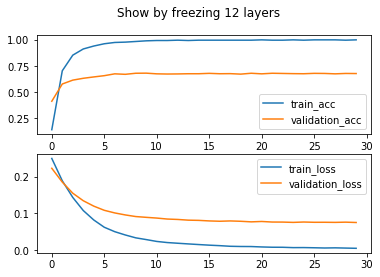

In [37]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Show by freezing 12 layers')
ax1.plot(torch.tensor(train_log[0] , device = 'cpu').tolist())
ax1.plot(torch.tensor(valid_log[0] , device = 'cpu').tolist())
ax1.legend(['train_acc','validation_acc'])
ax2.plot(torch.tensor(train_log[1] , device = 'cpu').tolist())
ax2.plot(torch.tensor(valid_log[1] , device = 'cpu').tolist())
ax2.legend(['train_loss','validation_loss'])

In [38]:
test_acc =test(model,device,label_maps,test_loader,len(test_data),tokenizer)

correct : 731
total : 1076


In [39]:
print(f'Accuracy : {100 * test_acc} %')  

Accuracy : 67.93680297397769 %


In [40]:
modelx = simcse

In [41]:
# Load model and retrieve attention weights
from transformers import BertTokenizer, BertForSequenceClassification
from bertviz import head_view, model_view
from transformers import BertTokenizer, BertModel
modelx = modelx.to('cpu')
model_version = 'bert-base-uncased'

#model = BertForSequenceClassification.from_pretrained(model_version, output_attentions=True)
#modelx = modelx.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version)
sentence_a = "what is tomorrow's alarm time set to"
sentence_b = "please let me know the morning alarm time for weekdays"
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt')
input_ids = inputs['input_ids']
token_type_ids = inputs['token_type_ids']
attention = modelx(input_ids, token_type_ids=token_type_ids)[-1]
sentence_b_start = token_type_ids[0].tolist().index(1)
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list) 

In [42]:
attention_unfreeze=attention

In [43]:
model_view(attention,tokens)

<IPython.core.display.Javascript object>